In [3]:
#Berikut ini adalah code untuk menampilkan video live stream dari kamera 
#framenya diperkecil menjadi setengahnya
#untuk menutup frame, klik key 'q'

import cv2

cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    cv2.imshow('Input', frame)
    
    if cv2.waitKey(1) & 0xff == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
#Berikut ini merupakan code yang menampilkan video live stream dari kamera
#kemudian anda dapat menggunakan mouse input dan membuat persegi di mana
#gambar pada persegi akan diubah menjadi citra negatif

import cv2
import numpy as np

def draw_rectangle(event, x, y, flags, params):
    global x_init, y_init, drawing, top_left_pt, bottom_right_pt
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        x_init, y_init = x, y
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            top_left_pt = (min(x_init, x), min(y_init, y))
            bottom_right_pt = (max(x_init, x), max(y_init, y))
            img[y_init:y, x_init:x] = 255 - img[y_init:y, x_init:x] #proses mengubah jadi negatif
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        top_left_pt = (min(x_init, x), min(y_init, y))
        bottom_right_pt = (max(x_init, x), max(y_init, y))
        img[y_init:y, x_init:x] = 255 - img[y_init:y, x_init:x] #proses mengubah jadi negatif

if __name__=='__main__':
    drawing = False
    top_left_pt, bottom_right_pt = (-1,-1), (-1,-1)
    
    cap = cv2.VideoCapture(0)
    
    # Check if the webcam is opened correctly
    if not cap.isOpened():
        raise IOError("Cannot open webcam")
        
    cv2.namedWindow('Webcam')
    cv2.setMouseCallback('Webcam', draw_rectangle)
    
    while True:
        ret, frame = cap.read()
        img = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        
        (x0,y0), (x1,y1) = top_left_pt, bottom_right_pt
        img[y0:y1, x0:x1] = 255 - img[y0:y1, x0:x1]
        
        cv2.imshow('Webcam', img)
        
        if cv2.waitKey(1) & 0xff == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

(-0.5, 639.5, 479.5, -0.5)

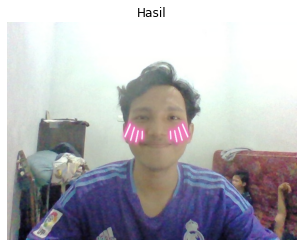

In [16]:
import numpy as np
from matplotlib import pyplot as plt 
import cv2

face_cascade = cv2.CascadeClassifier('cascades/haarcascade_frontalface_default.xml')

blush = cv2.imread('blush.png', -1)

#Mengambil live Capture dari source camera, 
# #nilai parameter dapat diganti dengan camera yg tersedia
camera = cv2.VideoCapture(0) 
camera.set(cv2.CAP_PROP_FPS, 30)

#Jika camera gagal terbuka akan ditampilkan pesan error
if not camera.isOpened():
    print("\nWebcam Gagal terbuka !!")
    exit()

#Fungsi filterInput berguna untuk meletakkan gambar filter di layer atas
#nantinya gambar filter akan berada diatas gambar dari camera
def filterInput(src, overlay, pos=(0, 0), scale=1):
    overlay = cv2.resize(overlay, (0, 0), fx=scale, fy=scale)
    h, w, _ = overlay.shape  
    rows, cols, _ = src.shape  
    y, x = pos[0], pos[1]  

    for i in range(h):
        for j in range(w):
            if x + i >= rows or y + j >= cols:
                continue
            alpha = float(overlay[i][j][3] / 255.0)  # read the alpha channel
            src[x + i][y + j] = alpha * overlay[i][j][:3] + (1 - alpha) * src[x + i][y + j]
    return src

while 1:
    ret, img = camera.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.2, 5, 0, (120, 120), (350, 350))
    
    #loop ini berguna untuk mentracking wajah
    #Kemudian akan memanggil fungis filterInput untuk meletakkan gambar filter
    #gambar filter akan diletakkan sesuai dengan arah pergerakan wajah
    for (x, y, w, h) in faces:
        if h > 0 and w > 0:
            #Section ini berguna untuk meletakkan gambar filter di area tengah/pipi
            blush_minimum = int(y + 1.0 * h / 3)
            blush_maximum = int(y + 2.5 * h / 3)
            blush_image = blush_maximum - blush_minimum

            blush_colorize = img[blush_minimum:blush_maximum, x:x + w]
            follow_size = cv2.resize(blush, (w, blush_image), interpolation=cv2.INTER_CUBIC)
        
            filterInput(blush_colorize, follow_size)

    cv2.imshow('Blush Filter', img)

    cv2.imwrite('Output_image.jpg', img)

    #Window OpenCV akan tertutup saat ditekan tombol "e"
    key = cv2.waitKey(1) & 0xFF
    if key == ord("e"):
        break

camera.release()
cv2.destroyAllWindows()


# Mencetak hasil output gambar
hasil = cv2.imread('Output_image.jpg')  

plt.imshow(cv2.cvtColor(hasil, cv2.COLOR_BGR2RGB))
plt.title("Hasil")
plt.axis('off')